In [1]:
import numpy as np
import scipy
import scipy.linalg
import random
import math
import matplotlib.pyplot as plt
import numpy as np
from scipy.linalg import qr, svd
from tqdm import tqdm
from scipy.sparse import lil_matrix, csr_matrix
import cmath

In [ ]:
def H(num):
    H = np.diag(np.ones(num-1),-1)+np.diag(np.ones(num-1),1) + np.diag(np.ones(num-2),-2)+np.diag(np.ones(num-2),2)
    H[num-1,0]=H[0,num-1]= H[num-2,0]=H[0,num-2]=1

    return H


In [28]:
import numpy as np
from scipy.sparse import lil_matrix
from itertools import combinations

def basis_states(L, filling_fraction=0.5):
    """Generate all basis states with the specified filling fraction."""
    num_particles = int(L * filling_fraction)  # Half filling
    print(num_particles)
    states = []
    for particle_sites in combinations(range(L), num_particles):
        state = np.zeros(L, dtype=int)
        state[list(particle_sites)] = 1
        states.append(state)
    return np.array(states)

def index_of_state(state, basis):
    """Find the index of a state in the basis array."""
    for idx, basis_state in enumerate(basis):
        if np.array_equal(state, basis_state):
            return idx
    return None

def construct_hamiltonian(L, J, V, J_prime, filling_fraction=0.5):
    basis = basis_states(L, filling_fraction)  # Generate all basis states at half-filling
    num_states = len(basis)
    H = lil_matrix((num_states, num_states), dtype=complex)
    
    # Loop over each basis state and construct Hamiltonian
    for i, state in enumerate(basis):
        # On-site interaction (n_j * n_{j+1})
        for j in range(L):
            n_j = state[j]
            n_j1 = state[(j + 1) % L]  # Periodic boundary condition
            H[i, i] += V * n_j * n_j1  # Diagonal term for nearest-neighbor interaction

        # Nearest-neighbor hopping (J/2 * (b_j^dag b_{j+1} + h.c.))
        for j in range(L):
            if state[j] == 1 and state[(j + 1) % L] == 0:
                # Create a new state with hopping
                new_state = state.copy()
                new_state[j] = 0
                new_state[(j + 1) % L] = 1
                new_index = index_of_state(new_state, basis)
                if new_index is not None:
                    H[i, new_index] += J / 2
                    H[new_index, i] += J / 2  # Hermitian conjugate

        # Next-nearest-neighbor hopping (J'/2 * (b_j^dag b_{j+2} + h.c.))
        for j in range(L):
            if state[j] == 1 and state[(j + 2) % L] == 0:
                # Create a new state with hopping
                new_state = state.copy()
                new_state[j] = 0
                new_state[(j + 2) % L] = 1
                new_index = index_of_state(new_state, basis)
                if new_index is not None:
                    H[i, new_index] += J_prime / 2
                    H[new_index, i] += J_prime / 2  # Hermitian conjugate

    return H.tocsr(),basis



In [29]:
def construct_effective_hamiltonian(H, L, gamma, filling_fraction=0.5):
    """Construct the effective non-Hermitian Hamiltonian H_eff."""
    nu = filling_fraction  # Filling factor
    decay_term = -1j * gamma * L * nu / 2  # Non-Hermitian decay term
    H_eff = H + decay_term * csr_matrix(np.identity(H.shape[0], dtype=complex))
    return H_eff



def schrodinger_rhs(psi, H_eff):
    """Calculate the RHS of the Schrödinger equation with H_eff."""
    return -1j * H_eff.dot(psi)

def rk4_step(psi, H_eff, dt):
    """Perform a single RK4 step for non-unitary evolution."""
    k1 = dt * schrodinger_rhs(psi, H_eff)
    k2 = dt * schrodinger_rhs(psi + 0.5 * k1, H_eff)
    k3 = dt * schrodinger_rhs(psi + 0.5 * k2, H_eff)
    k4 = dt * schrodinger_rhs(psi + k3, H_eff)
    psit=  psi + (k1 + 2 * k2 + 2 * k3 + k4) / 6

    return psit/np.linalg.norm(psit)

def quantum_jump(psi, basis, gamma, L):
    # Calculate jump probabilities based on the expectation values of n_j operators
    jump_probabilities = np.zeros(L)
    n_j_operator = np.zeros((L,len(psi)))
    for j in range(L):
        for i, state in enumerate(basis):
            if state[j] == 1:  # If the j-th site is occupied
                n_j_operator[j,i] = psi[i]
        # print(n_j_operator)
        jump_probabilities[j] = np.sqrt(np.dot(psi,n_j_operator[j]))


    # Normalize probabilities and choose jump site
    total_prob = np.sum(jump_probabilities)
    if total_prob > 0:
        jump_probabilities /= total_prob  # Normalize jump probabilities
        jump_site = np.random.choice(range(L), p=jump_probabilities)
        
        # Apply the jump operator at jump_site and renormalize
        psi = n_j_operator[jump_site]/np.sqrt(np.dot(psi,n_j_operator[jump_site]))
            
    return psi

def solve_schrodinger_with_jumps(psi0, H_eff, t_final, dt, gamma, L, filling_fraction=0.5):
    """Solve the Schrödinger equation with quantum jumps based on a constant rate."""
    psi = psi0
    times = [0]
    psi_t = [psi0]
    t = 0

    # Set initial jump interval based on gamma
    nu = filling_fraction  # Filling fraction
    tau = -2 * np.log(np.random.rand()) / (L * gamma * nu)

    while t < t_final:
        # Update the wavefunction using RK4 for non-unitary evolution
        psi = rk4_step(psi, H_eff, dt)
        t += dt
        
        # Check for quantum jump based on tau
        if t >= tau:
            # Normalize state and perform a quantum jump
            psi = psi / np.linalg.norm(psi)
            psi = quantum_jump(psi, basis_states(L, filling_fraction), gamma, L)
            
            # Re-sample the next jump time
            tau = t + -2 * np.log(np.random.rand()) / (L * gamma * nu)  # Recalculate the next jump time
        
        # Save the state and time
        times.append(t)
        psi_t.append(psi)

    return np.array(times), np.array(psi_t,dtype=complex)



In [ ]:
neel_state = [1, 0, 1, 0, 1, 0, 1, 0]
psi0 = np.zeros(len(basis_states(8)), dtype=complex)
psi0[index_of_state(neel_state,basis_states(8) )] = 1.0  # Set the amplitude for the Néel state to 1


4
4


4
4
4


c:\Users\aniru\anaconda3\Lib\site-packages\scipy\sparse\linalg\_dsolve\linsolve.py:412: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format', SparseEfficiencyWarning)
c:\Users\aniru\anaconda3\Lib\site-packages\scipy\sparse\linalg\_dsolve\linsolve.py:302: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


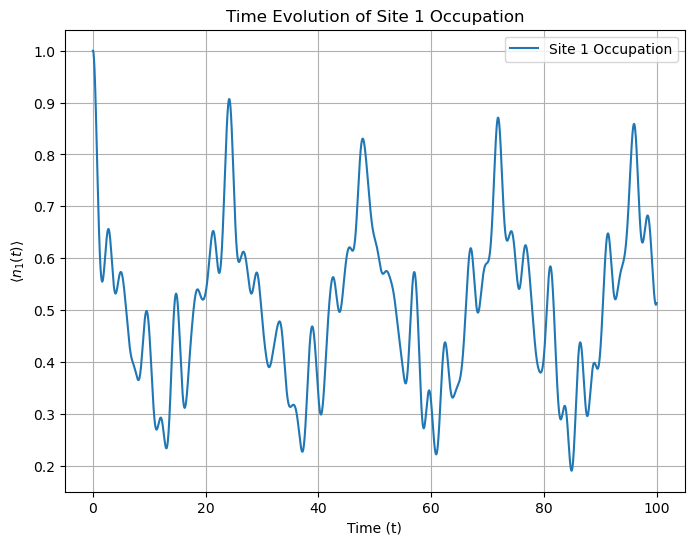

In [ ]:
import numpy as np
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import expm

def time_evolve_state(psi0, H, times):
    """
    Evolve the quantum state under a time-independent Hamiltonian.

    Parameters:
    - psi0: Initial wavefunction (1D numpy array).
    - H: Hamiltonian (scipy sparse matrix).
    - times: Array of time points for evolution.

    Returns:
    - psi_t: Array of wavefunctions at each time point.
    """
    psi_t = [psi0]
    for t_idx in range(1, len(times)):
        dt = times[t_idx] - times[t_idx - 1]
        U = expm(-1j * H * dt)  # Time evolution operator
        psi_t.append(U.dot(psi_t[-1]))  # Evolve the state
    return np.array(psi_t)

def compute_expectation_site1(psi_t, basis):
    """
    Compute the expectation value of particle occupation at site 1 over time.

    Parameters:
    - psi_t: Array of wavefunctions (2D numpy array).
    - basis: Basis states (2D numpy array).

    Returns:
    - n1_t: Expectation value of particle occupation at site 1 over time.
    """
    n1_t = []
    for psi in psi_t:
        expectation = 0
        for i, state in enumerate(basis):
            if state[0] == 1:  # Site 1 is occupied
                expectation += np.abs(psi[i])**2  # Add the probability of the state
        n1_t.append(expectation)
    return np.array(n1_t)

# Parameters
L = 8  # Number of sites
J = 1
J_prime = 0.5
V = 1
filling_fraction = 0.5
t_final = 100
num_time_steps = 10001

# Generate Hamiltonian and basis
H, basis = construct_hamiltonian(L, J, V, J_prime, filling_fraction)

# Initial state: equal superposition of all basis states
neel_state = [1, 0, 1, 0, 1, 0, 1, 0]
psi0 = np.zeros(len(basis_states(8)), dtype=complex)
psi0[index_of_state(neel_state,basis_states(8) )] = 1.0  # Set the amplitude for the Néel state to 1


# Time evolution
time = np.linspace(0, t_final, num_time_steps)
psi_t = time_evolve_state(psi0, H, time)

# Compute expectation value of site 1 occupation
n1_t = compute_expectation_site1(psi_t, basis)

J_prime = 0.5
V = 1

# Generate Hamiltonian and basis
H, basis = construct_hamiltonian(L, J, V, J_prime, filling_fraction)

# Initial state: equal superposition of all basis states
neel_state = [1, 0, 1, 0, 1, 0, 1, 0]
psi0 = np.zeros(len(basis_states(8)), dtype=complex)
psi0[index_of_state(neel_state,basis_states(8) )] = 1.0  # Set the amplitude for the Néel state to 1


# Time evolution
time = np.linspace(0, t_final, num_time_steps)
psi_t = time_evolve_state(psi0, H, time)

# Compute expectation value of site 1 occupation
n1_t = compute_expectation_site1(psi_t, basis)












In [52]:
J_prime = 1
V = 1
t_final = 100
num_time_steps = 10001
# Generate Hamiltonian and basis
H, basis = construct_hamiltonian(L, J, V, J_prime, filling_fraction)
# Initial state: equal superposition of all basis states
neel_state = [1, 0, 1, 0, 1, 0, 1, 0]
psi0 = np.zeros(len(basis_states(8)), dtype=complex)
psi0[index_of_state(neel_state,basis_states(8) )] = 1.0  # Set the amplitude for the Néel state to 1

# Time evolution
time = np.linspace(0, t_final, num_time_steps)
psi_t = time_evolve_state(psi0, H, time)
# Compute expectation value of site 1 occupation
n1_t1 = compute_expectation_site1(psi_t, basis)






J_prime = 0
V = 1
# Generate Hamiltonian and basis
H, basis = construct_hamiltonian(L, J, V, J_prime, filling_fraction)
# Initial state: equal superposition of all basis states
neel_state = [1, 0, 1, 0, 1, 0, 1, 0]
psi0 = np.zeros(len(basis_states(8)), dtype=complex)
psi0[index_of_state(neel_state,basis_states(8) )] = 1.0  # Set the amplitude for the Néel state to 1

# Time evolution
time = np.linspace(0, t_final, num_time_steps)
psi_t = time_evolve_state(psi0, H, time)

# Compute expectation value of site 1 occupation
n1_t2 = compute_expectation_site1(psi_t, basis)


J_prime = 1
V = 0
# Generate Hamiltonian and basis
H, basis = construct_hamiltonian(L, J, V, J_prime, filling_fraction)
# Initial state: equal superposition of all basis states
neel_state = [1, 0, 1, 0, 1, 0, 1, 0]
psi0 = np.zeros(len(basis_states(8)), dtype=complex)
psi0[index_of_state(neel_state,basis_states(8) )] = 1.0  # Set the amplitude for the Néel state to 1

# Time evolution
time = np.linspace(0, t_final, num_time_steps)
psi_t = time_evolve_state(psi0, H, time)

# Compute expectation value of site 1 occupation
n1_t3 = compute_expectation_site1(psi_t, basis)






4
4
4


c:\Users\aniru\anaconda3\Lib\site-packages\scipy\sparse\linalg\_dsolve\linsolve.py:412: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format', SparseEfficiencyWarning)
c:\Users\aniru\anaconda3\Lib\site-packages\scipy\sparse\linalg\_dsolve\linsolve.py:302: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


4
4
4
4
4
4


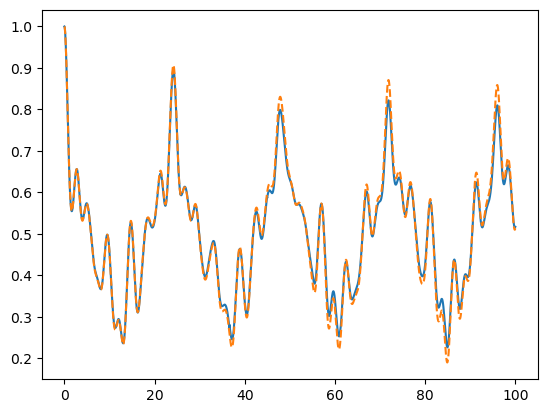

In [51]:
plt.plot(times, avg_n2_expectations,label="<n1(t)>")
plt.plot(time, n1_t,'--', label="Averaged Site 1 Occupation (50 Trajectories)")

In [ ]:
import numpy as np
from scipy.sparse import lil_matrix, csr_matrix
from itertools import combinations
import matplotlib.pyplot as plt

# Define functions (basis_states, index_of_state, construct_hamiltonian, construct_effective_hamiltonian, 
# schrodinger_rhs, rk4_step, quantum_jump, calculate_n1_expectation as defined in previous responses)

# Modified solve function to account for multiple trajectories


def calculate_n1_expectation(psi_t, basis, site=1):
    """Calculate the expectation value <n_site> at each time step."""
    n1_expectations = []
    
    
    # Define the number operator n1 at the chosen site (site=1)
    n_site_operator = np.array([state[site] for state in basis], dtype=float)
    
    # Calculate <n_site(t)> = <psi(t) | n_site | psi(t)>
    for psi in psi_t:
        expectation = np.vdot(psi, n_site_operator * psi).real
        n1_expectations.append(expectation)
    
    return np.array(n1_expectations)



# def calculate_n1_expectation(psi_t, basis, site=1):
#     """Calculate the expectation value <n_site> at each time step."""
#     n1_expectations = []
#     n_site_operator = np.array([state[site-1] for state in basis], dtype=float)


    
#     # Calculate <n_site(t)> = <psi(t) | n_site | psi(t)>
#     for psi in psi_t:
#         # print(n_j_operator)
#         expectation = np.dot(psi,n_site_operator*psi)
#         n1_expectations.append(expectation)
    
#     return np.array(n1_expectations)
        
    







# Function to run multiple trajectories and average <n1(t)>
def average_n1_over_trajectories(L, J, V, J_prime, gamma, t_final, dt, num_trajectories):
    """Run multiple quantum jump trajectories and average <n1(t)>."""
    # Construct Hamiltonian and effective Hamiltonian
    H, basis = construct_hamiltonian(L, J, V, J_prime)
    H_eff = construct_effective_hamiltonian(H, L, gamma, filling_fraction=0.5)
    
    # Initial Neel state for L=8: alternating 1s and 0s
    neel_state = np.array([1 if i % 2 == 0 else 0 for i in range(L)])
    initial_index = index_of_state(neel_state, basis)
    psi0 = np.zeros(len(basis), dtype=complex)
    psi0[initial_index] = 1.0  # Set the amplitude for the Néel state to 1

    # Initialize storage for <n1(t)> over all trajectories
    
    all_n2_expectations = []

    # Run multiple trajectories
    for _ in range(num_trajectories):
        # Solve for one trajectory
        times, psi_t = solve_schrodinger_with_jumps(psi0, H_eff, t_final, dt, gamma, L)
        n1_expectations = calculate_n1_expectation(psi_t, basis, site=1)
        n2_expectations = calculate_n1_expectation(psi_t, basis, site=2)
        all_n1_expectations.append(n1_expectations)
        all_n2_expectations.append(n2_expectations)

    # Convert list to array and average across trajectories
    all_n1_expectations = np.array(all_n1_expectations)
    avg_n1_expectations = np.mean(all_n1_expectations, axis=0)

    all_n2_expectations = np.array(all_n2_expectations)
    avg_n2_expectations = np.mean(all_n2_expectations, axis=0)
    return times, avg_n1_expectations, avg_n2_expectations







In [53]:
import numpy as np
from scipy.sparse import lil_matrix, csr_matrix
from itertools import combinations
import matplotlib.pyplot as plt

# Define functions (basis_states, index_of_state, construct_hamiltonian, construct_effective_hamiltonian, 
# schrodinger_rhs, rk4_step, quantum_jump, calculate_n1_expectation as defined in previous responses)

# Modified solve function to account for multiple trajectories


def calculate_n1_expectation(psi_t, basis, site=1):
    """Calculate the expectation value <n_site> at each time step."""
    n1_expectations = []
    
    
    # Define the number operator n1 at the chosen site (site=1)
    n_site_operator = np.array([state[site] for state in basis], dtype=float)
    
    # Calculate <n_site(t)> = <psi(t) | n_site | psi(t)>
    for psi in psi_t:
        expectation = np.vdot(psi, n_site_operator * psi).real
        n1_expectations.append(expectation)
    
    return np.array(n1_expectations)








# Function to run multiple trajectories and average <n1(t)>
def average_n1_over_trajectories(L, J, V, J_prime, gamma, t_final, dt, num_trajectories):
    """Run multiple quantum jump trajectories and average <n1(t)>."""
    # Construct Hamiltonian and effective Hamiltonian
    H, basis = construct_hamiltonian(L, J, V, J_prime)
    H_eff = construct_effective_hamiltonian(H, L, gamma, filling_fraction=0.5)
    
    # Initial Neel state for L=8: alternating 1s and 0s
    neel_state = np.array([1 if i % 2 == 0 else 0 for i in range(L)])
    initial_index = index_of_state(neel_state, basis)
    psi0 = np.zeros(len(basis), dtype=complex)
    psi0[initial_index] = 1.0  # Set the amplitude for the Néel state to 1

    # Initialize storage for <n1(t)> over all trajectories
    
    all_n2_expectations = []

    # Run multiple trajectories
    for _ in range(num_trajectories):
        # Solve for one trajectory
        times, psi_t = solve_schrodinger_with_jumps(psi0, H_eff, t_final, dt, gamma, L)
        
        n2_expectations = calculate_n1_expectation(psi_t, basis, site=2)
        
        all_n2_expectations.append(n2_expectations)

    # Convert list to array and average across trajectories
    
    all_n2_expectations = np.array(all_n2_expectations)
    avg_n2_expectations = np.mean(all_n2_expectations, axis=0)
    return times, avg_n2_expectations







4
4


C:\Users\aniru\AppData\Local\Temp\ipykernel_24268\3438894369.py:31: ComplexWarning: Casting complex values to real discards the imaginary part
  n_j_operator[j,i] = psi[i]
C:\Users\aniru\AppData\Local\Temp\ipykernel_24268\3438894369.py:33: ComplexWarning: Casting complex values to real discards the imaginary part
  jump_probabilities[j] = np.sqrt(np.dot(psi,n_j_operator[j]))


4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4


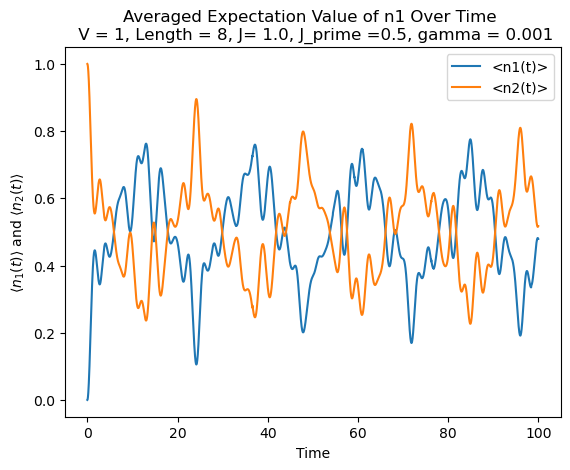

In [ ]:


# Parameters
L = 8                # Lattice size
J = 1.0              # Nearest-neighbor hopping term
V = 1             # On-site interaction term
J_prime = 0.5       # Next-nearest-neighbor hopping term
gamma = 0.001         # Decay rate for jumps
t_final = 100         # Final time for simulation
dt = 0.01            # Time step
num_trajectories = 100  # Number of trajectories to average

# Run the simulation and calculate averaged <n1(t)>
times, avg_n2_expectations = average_n1_over_trajectories(L, J, V, J_prime, gamma, t_final, dt, num_trajectories)

# Plot <n1(t)>
plt.plot(times, avg_n1_expectations, label="<n1(t)>")

plt.plot(times, avg_n2_expectations, label="<n2(t)>")
plt.xlabel("Time")
plt.ylabel(r"$\langle n_1(t) \rangle$ and $\langle n_2(t) \rangle$")
plt.title(f"Averaged Expectation Value of n1 Over Time \n V = {V}, Length = {L}, J= {J}, J_prime ={J_prime}, gamma = {gamma}")
plt.legend()
plt.show()

In [54]:

# Run the simulation and calculate averaged <n1(t)>
times, avg_n2_1 = average_n1_over_trajectories(8, 1, 1, 0, 0.001, 100, 0.01, 100)
times, avg_n2_2 = average_n1_over_trajectories(8, 1, 0, 1, 0.001, 100, 0.01, 100)
times, avg_n2_3 = average_n1_over_trajectories(8, 1, 1, 1, 0.001, 100, 0.01, 100)
times, avg_n2_4 = average_n1_over_trajectories(8, 1, 0, 0, 0.001, 100, 0.01, 100)


# plt.plot(times, avg_n2_expectations, label="<n2(t)>")
# plt.xlabel("Time")
# plt.ylabel(r"$\langle n_1(t) \rangle$ and $\langle n_2(t) \rangle$")
# plt.title(f"Averaged Expectation Value of n1 Over Time \n V = {V}, Length = {L}, J= {J}, J_prime ={J_prime}, gamma = {gamma}")
# plt.legend()
# plt.show()

4
4


C:\Users\aniru\AppData\Local\Temp\ipykernel_24268\3438894369.py:31: ComplexWarning: Casting complex values to real discards the imaginary part
  n_j_operator[j,i] = psi[i]
C:\Users\aniru\AppData\Local\Temp\ipykernel_24268\3438894369.py:33: ComplexWarning: Casting complex values to real discards the imaginary part
  jump_probabilities[j] = np.sqrt(np.dot(psi,n_j_operator[j]))


4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4


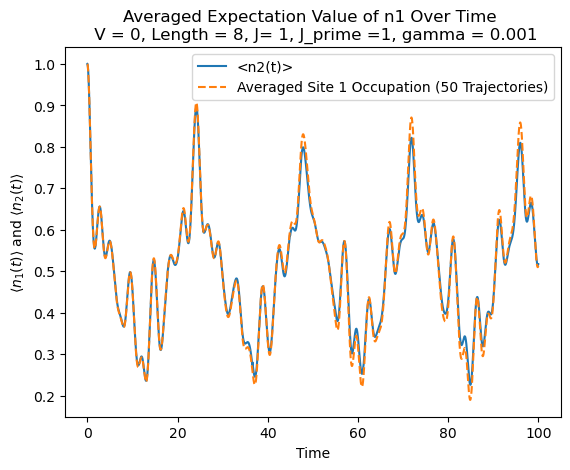

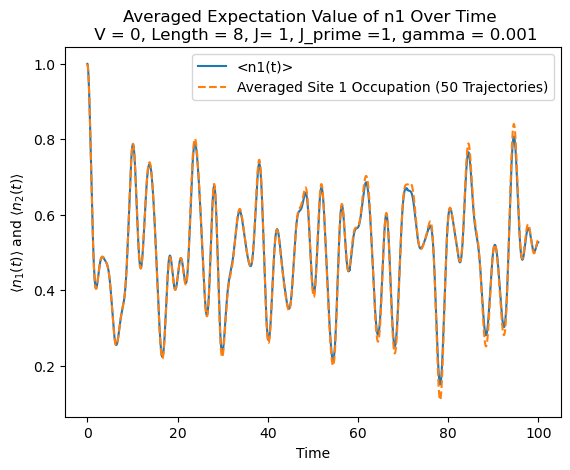

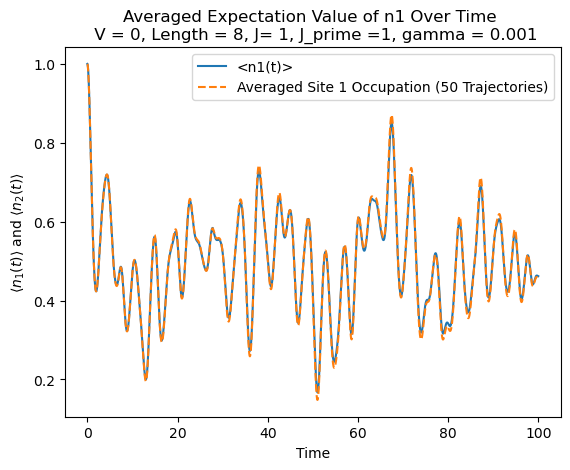

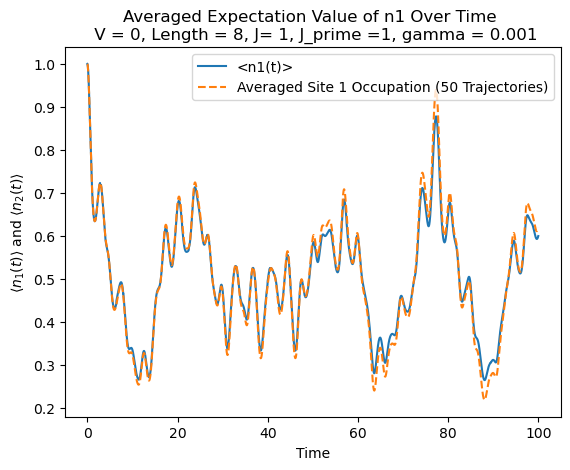

In [ ]:
plt.plot(times, avg_n2_expectations, label="<n2(t)>")
plt.plot(time, n1_t,'--', label="Averaged Site 1 Occupation (50 Trajectories)")
plt.xlabel("Time")
plt.ylabel(r"$\langle n_1(t) \rangle$ and $\langle n_2(t) \rangle$")
plt.title(f"Averaged Expectation Value of n1 Over Time \n V = {V}, Length = {L}, J= {J}, J_prime ={J_prime}, gamma = {gamma}")
plt.legend()
plt.show()

plt.plot(times, avg_n2_1,label="<n1(t)>")
plt.plot(time, n1_t2,'--', label="Averaged Site 1 Occupation (50 Trajectories)")
plt.xlabel("Time")
plt.ylabel(r"$\langle n_1(t) \rangle$ and $\langle n_2(t) \rangle$")
plt.title(f"Averaged Expectation Value of n1 Over Time \n V = {V}, Length = {L}, J= {J}, J_prime ={J_prime}, gamma = {gamma}")
plt.legend()
plt.show()

plt.plot(times, avg_n2_2,label="<n1(t)>")
plt.plot(time, n1_t3,'--', label="Averaged Site 1 Occupation (50 Trajectories)")
plt.xlabel("Time")
plt.ylabel(r"$\langle n_1(t) \rangle$ and $\langle n_2(t) \rangle$")
plt.title(f"Averaged Expectation Value of n1 Over Time \n V = {V}, Length = {L}, J= {J}, J_prime ={J_prime}, gamma = {gamma}")
plt.legend()
plt.show()

plt.plot(times, avg_n2_3,label="<n1(t)>")
plt.plot(time, n1_t1,'--', label="Averaged Site 1 Occupation (50 Trajectories)")
plt.xlabel("Time")
plt.ylabel(r"$\langle n_1(t) \rangle$ and $\langle n_2(t) \rangle$")
plt.title(f"Averaged Expectation Value of n1 Over Time \n V = {V}, Length = {L}, J= {J}, J_prime ={J_prime}, gamma = {gamma}")
plt.legend()
plt.show()


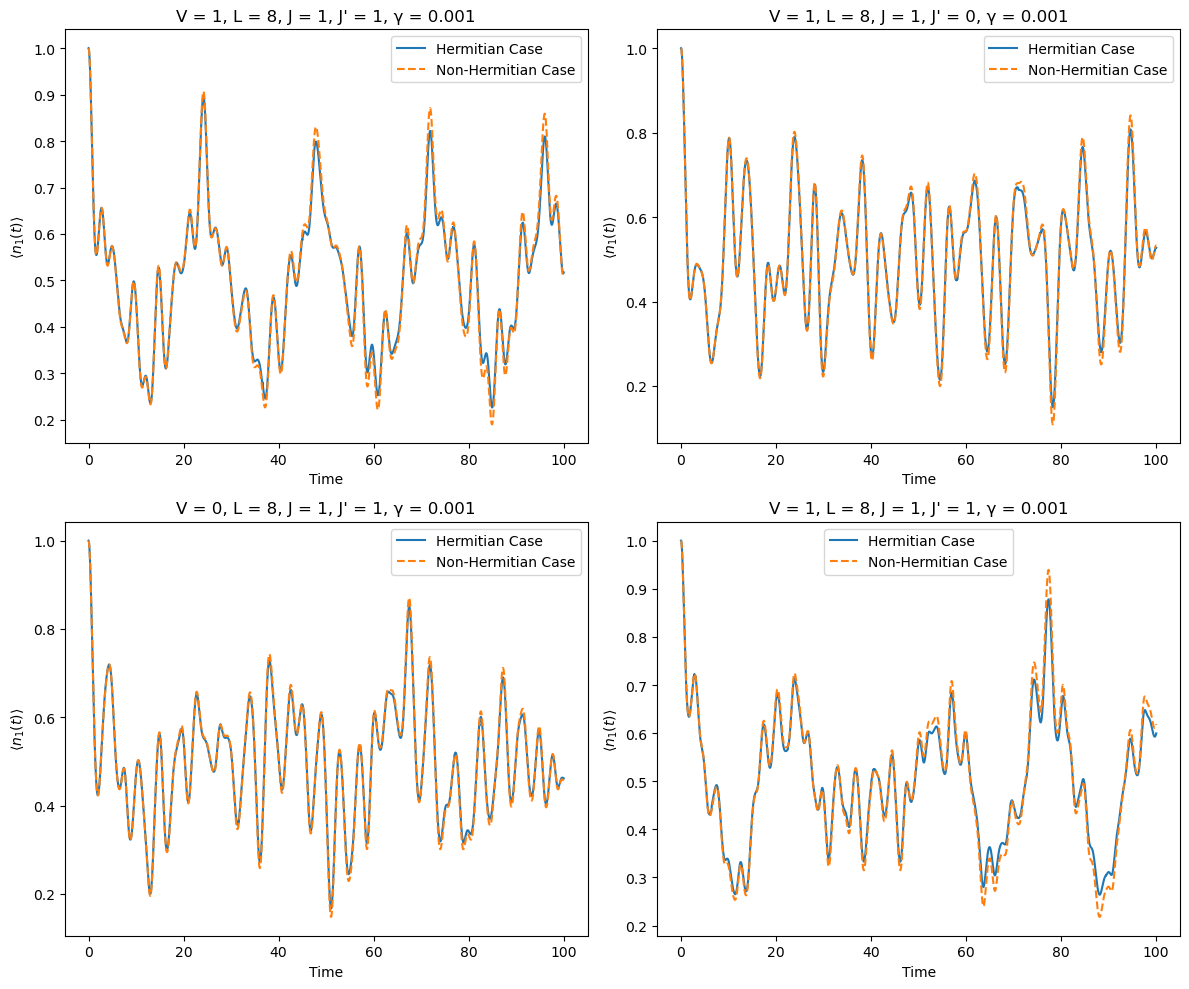

In [61]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))  # Create a 2x2 grid of subplots

# Hermitian and Non-Hermitian case labels
hermitian_label = "Hermitian Case"
non_hermitian_label = "Non-Hermitian Case"

# Plot 1
axs[0, 0].plot(times, avg_n2_expectations, label=hermitian_label)
axs[0, 0].plot(time, n1_t, '--', label=non_hermitian_label)
axs[0, 0].set_xlabel("Time")
axs[0, 0].set_ylabel(r"$\langle n_1(t) \rangle$")
axs[0, 0].set_title(f"V = 1, L = 8, J = 1, J' = {J_prime}, γ = 0.001")
axs[0, 0].legend()

# Plot 2
axs[0, 1].plot(times, avg_n2_1, label=hermitian_label)
axs[0, 1].plot(time, n1_t2, '--', label=non_hermitian_label)
axs[0, 1].set_xlabel("Time")
axs[0, 1].set_ylabel(r"$\langle n_1(t) \rangle $")
axs[0, 1].set_title(f"V = 1, L = 8, J = 1, J' = 0, γ = 0.001")
axs[0, 1].legend()

# Plot 3
axs[1, 0].plot(times, avg_n2_2, label=hermitian_label)
axs[1, 0].plot(time, n1_t3, '--', label=non_hermitian_label)
axs[1, 0].set_xlabel("Time")
axs[1, 0].set_ylabel(r"$\langle n_1(t) \rangle$")
axs[1, 0].set_title(f"V = {V}, L = 8, J = 1, J' = 1, γ = 0.001")
axs[1, 0].legend()

# Plot 4
axs[1, 1].plot(times, avg_n2_3, label=hermitian_label)
axs[1, 1].plot(time, n1_t1, '--', label=non_hermitian_label)
axs[1, 1].set_xlabel("Time")
axs[1, 1].set_ylabel(r"$\langle n_1(t) \rangle$ ")
axs[1, 1].set_title(f"V = 1, L = 8, J = 1, J' = 1, γ = 0.001")
axs[1, 1].legend()

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


In [ ]:
def calculate_site_expectations(psi_t, basis, L):
    """Calculate the expectation values <n_j(t)> for all sites over time."""
    site_expectations = np.zeros((L, len(psi_t)))
    for site in range(L):
        # Define the number operator n_j for site `site`
        n_j_operator = np.array([state[site] for state in basis], dtype=float)
        
        # Calculate <n_j(t)> for all time steps
        for t_idx, psi in enumerate(psi_t):
            site_expectations[site, t_idx] = np.vdot(psi, n_j_operator * psi).real
    return site_expectations




def average_site_expectations_over_trajectories(L, J, V, J_prime, gamma, t_final, dt, num_trajectories):
    """Run multiple quantum jump trajectories and calculate averaged <n_j(t)> for all sites."""
    # Construct Hamiltonian and effective Hamiltonian
    H, basis = construct_hamiltonian(L, J, V, J_prime)
    H_eff = construct_effective_hamiltonian(H, L, gamma, filling_fraction=0.5)
    
    # Initial Neel state for L=8: alternating 1s and 0s
    neel_state = np.array([1 if i % 2 == 0 else 0 for i in range(L)])
    initial_index = index_of_state(neel_state, basis)
    psi0 = np.zeros(len(basis), dtype=complex)
    psi0[initial_index] = 1.0  # Set the amplitude for the Néel state to 1

    # Initialize storage for site occupations across all trajectories
    all_site_expectations = []

    # Run multiple trajectories
    for _ in range(num_trajectories):
        # Solve for one trajectory
        times, psi_t = solve_schrodinger_with_jumps(psi0, H_eff, t_final, dt, gamma, L)
        site_expectations = calculate_site_expectations(psi_t, basis, L)
        all_site_expectations.append(site_expectations)

    # Convert list to array and average across trajectories
    all_site_expectations = np.array(all_site_expectations)
    avg_site_expectations = np.mean(all_site_expectations, axis=0)  # Average across trajectories
    return times, avg_site_expectations









In [ ]:
import numpy as np
from scipy.sparse import lil_matrix, csr_matrix
from itertools import combinations
import matplotlib.pyplot as plt

# Define functions (basis_states, index_of_state, construct_hamiltonian, construct_effective_hamiltonian, 
# schrodinger_rhs, rk4_step, quantum_jump, calculate_n1_expectation as defined in previous responses)

# Modified solve function to account for multiple trajectories



def calculate_n1_expectation(psi_t, basis, site):
    """Calculate the expectation value <n_site> at each time step."""
    n1_expectations = []
    
    
    # Define the number operator n1 at the chosen site (site=1)
    n_site_operator = np.array([state[site] for state in basis], dtype=float)
    
    # Calculate <n_site(t)> = <psi(t) | n_site | psi(t)>
    for psi in psi_t[15001:-1]:
        expectation = np.vdot(psi, n_site_operator * psi).real
        n1_expectations.append(expectation)
    
    return np.mean(np.array(n1_expectations),axis=0)


# Function to run multiple trajectories and average <n1(t)>
def average_n1_over_trajectories(L, J, V, J_prime, gamma, t_final, dt, num_trajectories):
    """Run multiple quantum jump trajectories and average <n1(t)>."""
    # Construct Hamiltonian and effective Hamiltonian
    H, basis = construct_hamiltonian(L, J, V, J_prime)
    H_eff = construct_effective_hamiltonian(H, L, gamma, filling_fraction=0.5)
    
    # Initial Neel state for L=8: alternating 1s and 0s
    neel_state = np.array([1 if i % 2 == 0 else 0 for i in range(L)])
    initial_index = index_of_state(neel_state, basis)
    psi0 = np.zeros(len(basis), dtype=complex)
    psi0[initial_index] = 1.0  # Set the amplitude for the Néel state to 1

    # Initialize storage for <n1(t)> over all trajectories
    n1_exp = np.zeros((num_trajectories,L))

    # Run multiple trajectories
    for traj in tqdm(range(num_trajectories)):
        # Solve for one trajectory
        times, psi_t = solve_schrodinger_with_jumps(psi0, H_eff, t_final, dt, gamma, L)
        for j in range(1,L):
            n1_expectations = calculate_n1_expectation(psi_t, basis, site=j)
            n1_exp[traj,j]=n1_expectations 
    # Convert list to array and average across trajectories
        
    
    avg_n1_expectations = np.mean(n1_exp[:,1:], axis=0)

    
    return times,n1_exp, np.sqrt(avg_n1_expectations)

# Parameters
L = 10              # Lattice size
J = 1.0              # Nearest-neighbor hopping term
V = 1             # On-site interaction term
J_prime = 0       # Next-nearest-neighbor hopping term      # Decay rate for jumps
t_final = 200         # Final time for simulation
dt = 0.01            # Time step
num_trajectories = 100  # Number of trajectories to average

# Run the simulation and calculate averaged <n1(t)>
times,B, C = average_n1_over_trajectories(L, J, V, J_prime, 0.1, t_final, dt, num_trajectories)





In [ ]:
L

In [ ]:
D

In [ ]:
times,D, E = average_n1_over_trajectories(L, J, V, J_prime, 1, t_final, dt, num_trajectories)
times,F, G = average_n1_over_trajectories(L, J, V, J_prime, 10, t_final, dt, num_trajectories)


In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(np.array([2,3,4,5,6,7,8,9,10]), C,'-o', label=r'$\sqrt{\langle n(t) \rangle}  , \gamma = 0.1$' )
plt.plot(np.array([2,3,4,5,6,7,8,9,10]), E, '-o',label=r'$\sqrt{\langle n(t) \rangle} , \gamma = 1$')
plt.plot(np.array([2,3,4,5,6,7,8,9,10]),G, '-o',label=r'$\sqrt{\langle n(t) \rangle} , \gamma = 10$')
plt.legend()
plt.xlabel("Site Index (j)")
plt.ylabel(r'$\sqrt{\langle n(t) \rangle}$')

plt.title(f"Time Evolution of Site Occupations\n V={V}, L={L}, J={J}, J'={J_prime}")

plt.show()

In [ ]:
randm

In [ ]:
np.mean(randm, axis=0)

In [ ]:
B[:,1:]

In [ ]:
plt.plot(times, avg_n1_expectations, label="<n1(t)>")

plt.plot(times, avg_n2_expectations, label="<n2(t)>")
plt.xlabel("Time")
plt.ylabel(r"$\langle n_1(t) \rangle$ and $\langle n_2(t) \rangle$")
plt.title(f"Averaged Expectation Value of n1 Over Time \n V = {V}, Length = {L}, J= {J}, J_prime ={J_prime}, gamma = {gamma}")
plt.legend()
plt.show()


In [ ]:
n_site_operator = np.array([state[0] for state in basis_states(4)], dtype=float)
        

In [ ]:
def quantum_jump(psi, basis, gamma, L):
    # Calculate jump probabilities based on the expectation values of n_j operators
    jump_probabilities = np.zeros(L)
    n_j_operator = np.zeros((L,len(psi)))
    for j in range(L):
        for i, state in enumerate(basis):
            if state[j] == 1:  # If the j-th site is occupied
                n_j_operator[j,i] = psi[i]
        print(n_j_operator)
        jump_probabilities[j] = gamma * np.sqrt(np.sum(np.dot(psi,n_j_operator[j])))


    # Normalize probabilities and choose jump site
    total_prob = np.sum(jump_probabilities)
    if total_prob > 0:
        jump_probabilities /= total_prob  # Normalize jump probabilities
        jump_site = np.random.choice(range(L), p=jump_probabilities)
        
        # Apply the jump operator at jump_site and renormalize
        psi = n_j_operator[jump_site]/np.sqrt(np.sum(np.dot(psi,n_j_operator[jump_site])))
            
    return psi

In [ ]:
jump_probabilities = np.zeros(4)
psi = np.array([1/np.sqrt(3),0,1/np.sqrt(3),0,0,1/np.sqrt(3)])
n_j_operator = np.zeros((4,len(psi)))
for j in range(4):
    
    for i, state in enumerate(basis_states(4)):
        
        if state[j] == 1:  # If the j-th site is occupied
            
            n_j_operator[j,i] = psi[i]
    
    jump_probabilities[j] = gamma * np.sqrt(np.sum(np.dot(psi,n_j_operator[j])))
    
total_prob = np.sum(jump_probabilities)
if total_prob > 0:
    jump_probabilities /= total_prob
np.random.choice(range(4), p=jump_probabilities)

In [ ]:
from scipy.linalg import logm

def reduced_density_matrix(psi, basis, subsystem_sites):
    L = basis.shape[1]  # Number of sites
    subsystem_basis = [
        state[subsystem_sites] for state in basis
    ]  # Retain only subsystem sites
    subsystem_basis = np.unique(subsystem_basis, axis=0)  # Unique subsystem states
    dim_sub = len(subsystem_basis)

    # Map subsystem states to indices
    subsystem_index_map = {
        tuple(state): idx for idx, state in enumerate(subsystem_basis)
    }

    rho_A = np.zeros((dim_sub, dim_sub), dtype=complex)
    for i, state_i in enumerate(basis):
        for j, state_j in enumerate(basis):
            reduced_state_i = tuple(state_i[subsystem_sites])
            reduced_state_j = tuple(state_j[subsystem_sites])
            if (state_i[:len(subsystem_sites)]== state_j[:len(subsystem_sites)]).all():
                if reduced_state_i in subsystem_index_map and reduced_state_j in subsystem_index_map:
                    idx_i = subsystem_index_map[reduced_state_i]
                    idx_j = subsystem_index_map[reduced_state_j]
                    rho_A[idx_i, idx_j] += psi[i] * np.conj(psi[j])            

    return rho_A


def von_neumann_entropy(rho):
    eigenvalues = np.linalg.eigvalsh(rho)  # Compute eigenvalues of Hermitian matrix
    eigenvalues = eigenvalues[eigenvalues > 1e-10]  # Exclude very small eigenvalues
    entropy = -np.sum(eigenvalues * np.log(eigenvalues))
    return entropy


def calculate_entropy(psi_t, basis, subsystem_sites):
    entropies = []
    for psi in tqdm(psi_t):
        rho_A = reduced_density_matrix(psi, basis, subsystem_sites)
        entropy = von_neumann_entropy(rho_A)
        entropies.append(entropy)
    return np.array(entropies)




In [ ]:
def average_S_over_trajectories(L, J, V, J_prime, gamma, t_final, dt, subsystem_sites,num_trajectories):
    """Run multiple quantum jump trajectories and average <n1(t)>."""
    # Construct Hamiltonian and effective Hamiltonian
    H, basis = construct_hamiltonian(L, J, V, J_prime)
    H_eff = construct_effective_hamiltonian(H, L, gamma, filling_fraction=0.5)
    
    # Initial Neel state for L=8: alternating 1s and 0s
    neel_state = np.array([1 if i % 2 == 0 else 0 for i in range(L)])
    initial_index = index_of_state(neel_state, basis)
    psi0 = np.zeros(len(basis), dtype=complex)
    psi0[initial_index] = 1.0  # Set the amplitude for the Néel state to 1

    # Initialize storage for <n1(t)> over all trajectories
    all_S_expectations = []
    
    
    # Run multiple trajectories
    for _ in tqdm(range(num_trajectories)):
        # Solve for one trajectory
        times, psi_t = solve_schrodinger_with_jumps(psi0, H_eff, t_final, dt, gamma, L)
        n1_expectations = calculate_entropy(psi_t, basis, subsystem_sites)
        all_S_expectations.append(n1_expectations)

    # Convert list to array and average across trajectories
    all_n1_expectations = np.array(all_S_expectations)
    avg_n1_expectations = np.mean(all_n1_expectations, axis=0)

    return times, avg_n1_expectations

In [ ]:
# Example Parameters
L = 8  # Number of sites
filling_fraction = 0.5  # Half-filling
J, V, J_prime, gamma = 1.0, 0, 0.5, 0.1  # Parameters
t_final = 100
dt = 0.1

# Generate Basis and Hamiltonian
basis = basis_states(L, filling_fraction)
H, _ = construct_hamiltonian(L, J, V, J_prime, filling_fraction)


# Calculate Entropy Over Time


In [ ]:
L= 8
filling_fraction = 0.5  # Half-filling
J, V, J_prime= 1.0, 0, 0.5 # Parameters

basis = basis_states(L, filling_fraction)
H, _ = construct_hamiltonian(L, J, V, J_prime, filling_fraction)
H_eff = construct_effective_hamiltonian(H, L, 0.1, filling_fraction)
neel_state = np.array([1 if i % 2 == 0 else 0 for i in range(L)])
initial_index = index_of_state(neel_state, basis)
psi0 = np.zeros(len(basis), dtype=complex)
psi0[initial_index] = 1.0

# times, psi_T = solve_schrodinger_with_jumps(psi0, H_eff, 50, 0.1, 0.1, 8, filling_fraction=0.5)


In [ ]:
psi01 = psi_T[-1]
times2, psi_T2 = solve_schrodinger_with_jumps(psi01, H_eff, 100, 0.1,0.1, 8, filling_fraction=0.5)

In [ ]:
subsystem_sites =  [1]
S = calculate_entropy(psi_T2,basis,subsystem_sites)



In [ ]:
S2 =calculate_entropy(psi_T2,basis,[5])
S3= calculate_entropy(psi_T2,basis,[1,5])

In [ ]:
(S+S2-S3).mean()

In [ ]:
gamma = np.array([0.1,1,1.2,1.6,2,2.4,3,4,5,6,7],dtype=complex)
L= 8
filling_fraction = 0.5  # Half-filling
J, V, J_prime= 1.0, 0, 0.5 # Parameters

basis = basis_states(L, filling_fraction)
H, _ = construct_hamiltonian(L, J, V, J_prime, filling_fraction)
neel_state = np.array([1 if i % 2 == 0 else 0 for i in range(L)])
initial_index = index_of_state(neel_state, basis)
psi0 = np.zeros(len(basis), dtype=complex)
psi0[initial_index] = 1.0


mutinf = []
for gamma in tqdm(gamma) :

    H_eff = construct_effective_hamiltonian(H, L, gamma, filling_fraction)
    times, psi_T = solve_schrodinger_with_jumps(psi0, H_eff, 50, 0.1, gamma, L, filling_fraction=0.5)
    psi01 = psi_T[-1]
    times2, psi_T2 = solve_schrodinger_with_jumps(psi01, H_eff, 100, 0.1,gamma, L, filling_fraction=0.5)
    S = calculate_entropy(psi_T2,basis,[1])
    S2 =calculate_entropy(psi_T2,basis,[5])
    S3= calculate_entropy(psi_T2,basis,[1,5])
    mutinf.append(S.mean() + S2.mean() - S3.mean())



In [ ]:

filling_fraction = 0.5  # Half-filling
J, V, J_prime= 1.0, 1, 0 # Parameters
t_final = 100
dt = 0.1



gamma = np.array([0.1,1,2,3,4,5,10])
sitearr = np.array([6,8,10])
diffsa = np.zeros((3,7))
for L in range(len(sitearr)):
    averageS = np.zeros((3,7))
    
    for i in range(len(gamma)):
        basis = basis_states(sitearr[L], filling_fraction)
        H, _ = construct_hamiltonian(sitearr[L], J, V, J_prime, filling_fraction)
        H_eff = construct_effective_hamiltonian(H, sitearr[L], gamma[i], filling_fraction)
        subsystem_sites =  list(range(sitearr[L] // 2, sitearr[L]))  # Trace out the second half of the system
        neel_state = np.array([1 if i % 2 == 0 else 0 for i in range(sitearr[L])])
        initial_index = index_of_state(neel_state, basis)
        psi0 = np.zeros(len(basis), dtype=complex)
        psi0[initial_index] = 1.0  # Set the amplitude for the Néel state to 1


        a1= []

        for t in range(50):
            times, psi_T = solve_schrodinger_with_jumps(psi0, H_eff, 100, 0.1, gamma[i], sitearr[L], filling_fraction=0.5)  # Trace out the second half of the system
            a1.append(list(psi_T[-1]))
        S = calculate_entropy(a1,basis,subsystem_sites)

        
        diffsa[L,i]= S.mean()

In [ ]:
diffsa

In [ ]:
d1 =np.array([[1.39474078, 0.85213349, 0.43110816, 0.25018393, 0.13514243,
        0.17800597, 0.04223172],
       [1.94997097, 0.99364149, 0.48936018, 0.27830292, 0.14565744,
        0.17872879, 0.08116686],
       [2.53781903, 1.10262325, 0.52694939, 0.31233552, 0.16860445,
        0.18645378, 0.10799263]])

d2 = np.array(d1).T

x_values = [3,4,5]
gamma = [0.1,1,2,3,4,5,10]
# Plot each column of the transposed data
for i in range(d2.shape[0]):
    plt.plot(x_values, d2[i], '-o', label=f'$\gamma$ = {gamma[i]}')

# Add labels, legend, and title
plt.xlabel('L/2')
plt.ylabel('$S( l_A = L/2)$')
plt.title('Entropy Across Different site lengths for various $\gamma$ \n V= 1 , J =1 , J_prime = 0')
plt.legend()
plt.grid(True)
plt.show()



In [ ]:
diffsa2 = np.array(diffsa).T

# Define x-axis values
x_values = [3, 4,5]
gamma = [0.1,1,2,3,4,5,10]
# Plot each column of the transposed data
for i in range(diffsa2.shape[0]):
    plt.plot(x_values, diffsa2[i], '-o', label=f'$\gamma$ = {gamma[i]}')

# Add labels, legend, and title
plt.xlabel('L/2')
plt.ylabel('$S( l_A = L/2)$')
plt.title('Entropy Across Different site lengths for various $\gamma$ \n V= 1 , J =1 , J_prime = 0')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
Entropy = [[2.039896940920768, 1.175964573525963, 0.7467710924232783, 0.5884340664154911, 0.4128053982800343, 0.32328301246010105, 0.1436138479924532], [2.5294565636984437, 1.35050757544277264, 0.8073549920599339, 0.550982239434552, 0.3979307855320123, 0.29292282299458383, 0.11061424570280368], [2.9164656880455476, 1.5263939154381, 0.85201154081024762, 0.5399220804773368, 0.3714695989298648, 0.3178688919402084, 0.1266485018471414], [3.1753012401429204, 1.7005743922685245, 0.8529008740393488, 0.5362004969155051, 0.3560829895887485, 0.28680596238085276, 0.09490698321359944]]

Entropy_T = np.array(Entropy).T

# Define x-axis values
x_values = [4, 5, 6, 7]
gamma = [0.1,1,2,3,4,5,10]
# Plot each column of the transposed data
for i in range(Entropy_T.shape[0]):
    plt.plot(x_values, Entropy_T[i], '-o', label=f'$\gamma$ = {gamma[i]}')

# Add labels, legend, and title
plt.xlabel('L/2')
plt.ylabel('$S( l_A = L/2)$')
plt.title('Entropy Across Different site lengths for various $\gamma$ \n V= 0 , J =1 , J_prime = 1')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
diffsa

In [ ]:
num_trajectories = 20
filling_fraction = 0.5  # Half-filling
J, V, J_prime= 1, 0, 1 # Parameters
t_final = 100
dt = 0.1
L = 8

#times, averageS = average_S_over_trajectories(L, J, V, J_prime, 0.1, t_final, dt, subsystem_sites,num_trajectories)  # Trace out the second half of the system
H_eff = construct_effective_hamiltonian(H, L, 0.1, filling_fraction)
subsystem_sites =  list(range(L // 2, L))  # Trace out the second half of the system
times, averageS = average_S_over_trajectories(6, 1, 0, 1, 0.1, t_final, dt, subsystem_sites,num_trajectories)  # Trace out the second half of the system
times, averageS2 = average_S_over_trajectories(6,  1, 0, 1, 1, t_final, dt, subsystem_sites,num_trajectories)  # Trace out the second half of the system
times, averageS3 = average_S_over_trajectories(6,  1, 0, 1, 2, t_final, dt, subsystem_sites,num_trajectories)  # Trace out the second half of the system
times, averageS4 = average_S_over_trajectories(6,  1, 0, 1, 2, t_final, dt, subsystem_sites,num_trajectories)  # Trace out the second half of the system


times, aerageS = average_S_over_trajectories(8, 1, 0, 1, 0.1, t_final, dt, subsystem_sites,num_trajectories)  # Trace out the second half of the system
times, aerageS2 = average_S_over_trajectories(8,  1, 0, 1, 1, t_final, dt, subsystem_sites,num_trajectories)  # Trace out the second half of the system
times, aerageS3 = average_S_over_trajectories(8,  1, 0, 1, 2, t_final, dt, subsystem_sites,num_trajectories)  # Trace out the second half of the system
times, aerageS3 = average_S_over_trajectories(8,  1, 0, 1, 2, t_final, dt, subsystem_sites,num_trajectories)  # Trace out the second half of the system


times, bverageS = average_S_over_trajectories(10, 1, 0, 1, 0.1, t_final, dt, subsystem_sites,num_trajectories)  # Trace out the second half of the system
times, bverageS2 = average_S_over_trajectories(10,  1, 0, 1, 1, t_final, dt, subsystem_sites,num_trajectories)  # Trace out the second half of the system
times, bverageS3 = average_S_over_trajectories(10,  1, 0, 1, 2, t_final, dt, subsystem_sites,num_trajectories)  # Trace out the second half of the system
times, bverageS3 = average_S_over_trajectories(10,  1, 0, 1, 2, t_final, dt, subsystem_sites,num_trajectories)  # Trace out the second half of the system





In [ ]:

# Plot Entropy vs Time

plt.plot(times, averageS, label="Entanglement Entropy $\gamma = 0.1$")
plt.plot(times, averageS2, label="Entanglement Entropy $\gamma = 1$")
plt.plot(times, averageS3, label="Entanglement Entropy $\gamma = 10$")

plt.xlabel("Time")
plt.ylabel("Entropy (S)")
plt.title(f"Entanglement Entropy vs Time \n V ={V}, J ={J}, J_prime ={J_prime}")
plt.legend()


In [ ]:
subsystem_sites =  list(range(3, 6))



times, averageS = average_S_over_trajectories(6, 1, 0, 1, 0.1, t_final, dt, subsystem_sites,25)  # Trace out the second half of the system
times, averageS2 = average_S_over_trajectories(6,  1, 0, 1, 1, t_final, dt, subsystem_sites,25)  # Trace out the second half of the system
times, averageS3 = average_S_over_trajectories(6,  1, 0, 1, 2, t_final, dt, subsystem_sites,25)  # Trace out the second half of the system
times, averageS3 = average_S_over_trajectories(6,  1, 0, 1, 10, t_final, dt, subsystem_sites,25)  # Trace out the second half of the system





times, aa1 = average_S_over_trajectories(6, 1, 0, 0.5, 0.1, 100, 0.1, subsystem_sites,25)  # Trace out the second half of the system
times, aa2 = average_S_over_trajectories(6, 1, 0, 0.5, 1, 100, 0.1, subsystem_sites,25)  # Trace out the second half of the system
times, aa3 = average_S_over_trajectories(6, 1, 0, 0.5, 2, 100, 0.1, subsystem_sites,25)  # Trace out the second half of the system
times, aa4 = average_S_over_trajectories(6, 1, 0, 0.5, 10, 100, 0.1, subsystem_sites,25)  # Trace out the second half of the system



times, aa5 = average_S_over_trajectories(6, 1, 1, 0.5, 0.1, 100, 0.1, subsystem_sites,25)  # Trace out the second half of the system
times, aa6 = average_S_over_trajectories(6, 1, 1, 0.5, 1, 100, 0.1, subsystem_sites,25)  # Trace out the second half of the system
times, aa7 = average_S_over_trajectories(6, 1, 1, 0.5, 2, 100, 0.1, subsystem_sites,25)  # Trace out the second half of the system
times, aa8 = average_S_over_trajectories(6, 1, 1, 0.5, 10, 100, 0.1, subsystem_sites,25)  # Trace out the second half of the system



times, aa9 = average_S_over_trajectories(6, 1, 1, 0, 0.1, 100, 0.1, subsystem_sites,25)  # Trace out the second half of the system
times, aa10 = average_S_over_trajectories(6, 1, 1, 0, 1, 100, 0.1, subsystem_sites,25)  # Trace out the second half of the system
times, aa11 = average_S_over_trajectories(6, 1, 1, 0, 2, 100, 0.1, subsystem_sites,25)  # Trace out the second half of the system
times, aa12 = average_S_over_trajectories(6, 1, 1, 0, 10, 100, 0.1, subsystem_sites,25)  # Trace out the second half of the system





In [ ]:
import matplotlib.pyplot as plt

# Assuming `times` is the same for all plots
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Flatten the axes for easier indexing
axs = axs.flatten()

# Subplot 1: First combination (2nd=1, 3rd=0, 4th=1)
axs[0].plot(times, averageS, label='$\gamma$ = 0.1')
axs[0].plot(times, averageS2, label='$\gamma$ = 1')
axs[0].plot(times, averageS3, label='$\gamma$= 10')
axs[0].legend()
axs[0].set_title('J=1, V=0, J_prime =1')
axs[0].set_xlabel('Time(t)')
axs[0].set_ylabel(r'$S(l_A = L/2,t)$')

# Subplot 2: Second combination (2nd=1, 3rd=0, 4th=0.5)
axs[1].plot(times, aa1, label='$\gamma$ = 0.1')
axs[1].plot(times, aa2, label='$\gamma$ = 1')
axs[1].plot(times, aa3, label='$\gamma$ = 2')
axs[1].plot(times, aa4, label='$\gamma$ = 10')
axs[1].legend()
axs[1].set_title('J=1, V=0, J_prime =0.5')
axs[1].set_xlabel('Time(t)')
axs[1].set_ylabel(r'$S(l_A = L/2,t)$')

# Subplot 3: Third combination (2nd=1, 3rd=1, 4th=0.5)
axs[2].plot(times, aa5, label='$\gamma$= 0.1')
axs[2].plot(times, aa6, label='$\gamma$ = 1')
axs[2].plot(times, aa7, label='$\gamma$ = 2')
axs[2].plot(times, aa8, label='$\gamma$= 10')
axs[2].legend()
axs[2].set_title('J=1, V=1, J_prime =1')
axs[2].set_xlabel('Time(t)')
axs[2].set_ylabel(r'$S(l_A = L/2,t)$')

# Subplot 4: Fourth combination (2nd=1, 3rd=1, 4th=0)
axs[3].plot(times, aa9, label='$\gamma$ = 0.1')
axs[3].plot(times, aa10, label='$\gamma$ = 1')
axs[3].plot(times, aa11, label='$\gamma$= 2')
axs[3].plot(times, aa12, label='$\gamma$ = 10')
axs[3].legend()
axs[3].set_title('J=1, V=1, J_prime =0')
axs[3].set_xlabel('Time(t)')
axs[3].set_ylabel(r'$S(l_A = L/2,t)$')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


In [ ]:
subsystem_sites =  list(range(4, 8))



times, aerageS = average_S_over_trajectories(8, 1, 0, 1, 0.1, t_final, dt, subsystem_sites,25)  # Trace out the second half of the system
times, aerageS2 = average_S_over_trajectories(8,  1, 0, 1, 1, t_final, dt, subsystem_sites,25)  # Trace out the second half of the system
times, aerageS3 = average_S_over_trajectories(8,  1, 0, 1, 2, t_final, dt, subsystem_sites,25)  # Trace out the second half of the system
times, aerageS3 = average_S_over_trajectories(8,  1, 0, 1, 2, t_final, dt, subsystem_sites,25)  # Trace out the second half of the system





times, a1 = average_S_over_trajectories(8, 1, 0, 0.5, 0.1, 100, 0.1, subsystem_sites,25)  # Trace out the second half of the system
times, a2 = average_S_over_trajectories(8, 1, 0, 0.5, 1, 100, 0.1, subsystem_sites,25)  # Trace out the second half of the system
times, a3 = average_S_over_trajectories(8, 1, 0, 0.5, 2, 100, 0.1, subsystem_sites,25)  # Trace out the second half of the system
times, a4 = average_S_over_trajectories(8, 1, 0, 0.5, 10, 100, 0.1, subsystem_sites,25)  # Trace out the second half of the system



times, a5 = average_S_over_trajectories(8, 1, 1, 0.5, 0.1, 100, 0.1, subsystem_sites,25)  # Trace out the second half of the system
times, a6 = average_S_over_trajectories(8, 1, 1, 0.5, 1, 100, 0.1, subsystem_sites,25)  # Trace out the second half of the system
times, a7 = average_S_over_trajectories(8, 1, 1, 0.5, 2, 100, 0.1, subsystem_sites,25)  # Trace out the second half of the system
times, a8 = average_S_over_trajectories(8, 1, 1, 0.5, 10, 100, 0.1, subsystem_sites,25)  # Trace out the second half of the system



times, a9 = average_S_over_trajectories(8, 1, 1, 0, 0.1, 100, 0.1, subsystem_sites,25)  # Trace out the second half of the system
times, a10 = average_S_over_trajectories(8, 1, 1, 0, 1, 100, 0.1, subsystem_sites,25)  # Trace out the second half of the system
times, a11 = average_S_over_trajectories(8, 1, 1, 0, 2, 100, 0.1, subsystem_sites,25)  # Trace out the second half of the system
times, a12 = average_S_over_trajectories(8, 1, 1, 0, 10, 100, 0.1, subsystem_sites,25)  # Trace out the second half of the system




In [ ]:
import matplotlib.pyplot as plt

# Assuming `times` is the same for all plots
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Flatten the axes for easier indexing
axs = axs.flatten()

# Subplot 1: First combination (2nd=1, 3rd=0, 4th=1)
axs[0].plot(times, aerageS, label='$\gamma$ = 0.1')
axs[0].plot(times, aerageS2, label='$\gamma$ = 1')
axs[0].plot(times, aerageS3, label='$\gamma$ = 10')
axs[0].legend()
axs[0].set_title('J=1, V=0, J_prime =1')
axs[0].set_xlabel('Time(t)')
axs[0].set_ylabel(r'$S(l_A = L/2,t)$')

# Subplot 2: Second combination (2nd=1, 3rd=0, 4th=0.5)
axs[1].plot(times, a1, label='$\gamma$ = 0.1')
axs[1].plot(times, a2, label='$\gamma$ = 1')
axs[1].plot(times, a3, label='$\gamma$ = 2')
axs[1].plot(times, a4, label='$\gamma$ = 10')
axs[1].legend()
axs[1].set_title('J=1, V=0, J_prime =0.5')
axs[1].set_xlabel('Time(t)')
axs[1].set_ylabel(r'$S(l_A = L/2,t)$')

# Subplot 3: Third combination (2nd=1, 3rd=1, 4th=0.5)
axs[2].plot(times, a5, label='$\gamma$ = 0.1')
axs[2].plot(times, a6, label='$\gamma$ = 1')
axs[2].plot(times, a7, label='$\gamma$ = 2')
axs[2].plot(times, a8, label='$\gamma$ = 10')
axs[2].legend()
axs[2].set_title('J=1, V=1, J_prime =0.5')
axs[2].set_xlabel('Time(t)')
axs[2].set_ylabel(r'$S(l_A = L/2,t)$')

# Subplot 4: Fourth combination (2nd=1, 3rd=1, 4th=0)
axs[3].plot(times, a9, label='$\gamma$ = 0.1')
axs[3].plot(times, a10, label='$\gamma$ = 1')
axs[3].plot(times, a11, label='$\gamma$ = 2')
axs[3].plot(times, a12, label='$\gamma$ = 10')
axs[3].legend()
axs[3].set_title('J=1, V=1, J_prime =0')
axs[3].set_xlabel('Time(t)')
axs[3].set_ylabel(r'$S(l_A = L/2,t)$')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


In [ ]:
subsystem_sites =  list(range(5, 10))


times, bverageS = average_S_over_trajectories(10, 1, 0, 1, 0.1, t_final, dt, subsystem_sites,num_trajectories)  # Trace out the second half of the system
times, bverageS2 = average_S_over_trajectories(10,  1, 0, 1, 1, t_final, dt, subsystem_sites,num_trajectories)  # Trace out the second half of the system
times, bverageS3 = average_S_over_trajectories(10,  1, 0, 1, 2, t_final, dt, subsystem_sites,num_trajectories)  # Trace out the second half of the system
times, bverageS3 = average_S_over_trajectories(10,  1, 0, 1, 2, t_final, dt, subsystem_sites,num_trajectories)  # Trace out the second half of the system



times, a1 = average_S_over_trajectories(10, 1, 0, 0.5, 0.1, 100, 0.1, subsystem_sites,25)  # Trace out the second half of the system
times, a2 = average_S_over_trajectories(10, 1, 0, 0.5, 1, 100, 0.1, subsystem_sites,25)  # Trace out the second half of the system
times, a3 = average_S_over_trajectories(10, 1, 0, 0.5, 2, 100, 0.1, subsystem_sites,25)  # Trace out the second half of the system
times, a4 = average_S_over_trajectories(10, 1, 0, 0.5, 10, 100, 0.1, subsystem_sites,25)  # Trace out the second half of the system





times, a5 = average_S_over_trajectories(10, 1, 1, 0.5, 0.1, 100, 0.1, subsystem_sites,25)  # Trace out the second half of the system
times, a6 = average_S_over_trajectories(10, 1, 1, 0.5, 1, 100, 0.1, subsystem_sites,25)  # Trace out the second half of the system
times, a7 = average_S_over_trajectories(10, 1, 1, 0.5, 2, 100, 0.1, subsystem_sites,25)  # Trace out the second half of the system
times, a8 = average_S_over_trajectories(10, 1, 1, 0.5, 10, 100, 0.1, subsystem_sites,25)  # Trace out the second half of the system


times, a9 = average_S_over_trajectories(10, 1, 1, 0, 0.1, 100, 0.1, subsystem_sites,25)  # Trace out the second half of the system
times, a10 = average_S_over_trajectories(10, 1, 1, 0, 1, 100, 0.1, subsystem_sites,25)  # Trace out the second half of the system
times, a11 = average_S_over_trajectories(10, 1, 1, 0, 2, 100, 0.1, subsystem_sites,25)  # Trace out the second half of the system
times, a12 = average_S_over_trajectories(10, 1, 1, 0, 10, 100, 0.1, subsystem_sites,25)  # Trace out the second half of the system





In [ ]:
plt.plot(times, aa1, label="Entanglement Entropy $\gamma = 0.1$")
plt.plot(times, aa2, label="Entanglement Entropy $\gamma = 2$")
plt.plot(times, aa4, label="Entanglement Entropy $\gamma = 10$")

plt.xlabel("Time")
plt.ylabel("Entropy (S)")
plt.title(f"Entanglement Entropy vs Time \n J =1, V =0 , J_prime 0.5")
plt.legend()

In [ ]:
filling_fraction = 0.5  # Half-filling
J, V, J_prime= 1.0, 1, 0 # Parameters
t_final = 100
dt = 0.1



gamma = np.array([0.1,1,2,3,4,5,10])
sitearr = np.array([6,8,10,12])
diffsa = np.zeros((3,7))
for L in range(len(sitearr)):
    averageS = np.zeros((3,7))
    
    for i in range(len(gamma)):
        basis = basis_states(sitearr[L], filling_fraction)
        H, _ = construct_hamiltonian(sitearr[L], J, V, J_prime, filling_fraction)
        H_eff = construct_effective_hamiltonian(H, sitearr[L], gamma[i], filling_fraction)
        subsystem_sites =  list(range(sitearr[L] // 2, sitearr[L]))  # Trace out the second half of the system
        neel_state = np.array([1 if i % 2 == 0 else 0 for i in range(sitearr[L])])
        initial_index = index_of_state(neel_state, basis)
        psi0 = np.zeros(len(basis), dtype=complex)
        psi0[initial_index] = 1.0  # Set the amplitude for the Néel state to 1


        a1= []

        for t in range(50):
            times, psi_T = solve_schrodinger_with_jumps(psi0, H_eff, 100, 0.1, gamma[i], sitearr[L], filling_fraction=0.5)  # Trace out the second half of the system
            a1.append(list(psi_T[-1]))
        S = calculate_entropy(a1,basis,subsystem_sites)

        
        diffsa[L,i]= S.mean()

In [ ]:
subsystem_sites =  list(range(4, 8))

times, b5 = average_S_over_trajectories(6, 1, 1, 0.5, 0.1, 100, 0.1, subsystem_sites,25)  # Trace out the second half of the system
times, b6 = average_S_over_trajectories(6, 1, 1, 0.5, 1, 100, 0.1, subsystem_sites,25)  # Trace out the second half of the system
times, b7 = average_S_over_trajectories(6, 1, 1, 0.5, 2, 100, 0.1, subsystem_sites,25)  # Trace out the second half of the system
times, b8 = average_S_over_trajectories(6, 1, 1, 0.5, 10, 100, 0.1, subsystem_sites,25)  # Trace out the second half of the system


times, aa5 = average_S_over_trajectories(8, 1, 1, 0.5, 0.1, 100, 0.1, subsystem_sites,25)  # Trace out the second half of the system
times, aa6 = average_S_over_trajectories(8, 1, 1, 0.5, 1, 100, 0.1, subsystem_sites,25)  # Trace out the second half of the system
times, aa7 = average_S_over_trajectories(8, 1, 1, 0.5, 2, 100, 0.1, subsystem_sites,25)  # Trace out the second half of the system
times, aa8 = average_S_over_trajectories(8, 1, 1, 0.5, 10, 100, 0.1, subsystem_sites,25)  # Trace out the second half of the system



times, a5 = average_S_over_trajectories(10, 1, 1, 0.5, 0.1, 100, 0.1, subsystem_sites,25)  # Trace out the second half of the system
times, a6 = average_S_over_trajectories(10, 1, 1, 0.5, 1, 100, 0.1, subsystem_sites,25)  # Trace out the second half of the system
times, a7 = average_S_over_trajectories(10, 1, 1, 0.5, 2, 100, 0.1, subsystem_sites,25)  # Trace out the second half of the system
times, a8 = average_S_over_trajectories(10, 1, 1, 0.5, 10, 100, 0.1, subsystem_sites,25)  # Trace out the second half of the system




In [ ]:
plt.plot(times, aa5, label="Entanglement Entropy $\gamma = 0.1$")
plt.plot(times, aa6, label="Entanglement Entropy $\gamma = 1$")

plt.plot(times, aa7, label="Entanglement Entropy $\gamma = 2$")
plt.plot(times, aa8, label="Entanglement Entropy $\gamma = 10$")

plt.xlabel("Time")
plt.ylabel("Entropy (S)")
plt.title(f"Entanglement Entropy vs Time \n J =1, V =1 , J_prime 0.5")
plt.legend()

In [ ]:
# average_S_over_trajectories(L, J, V, J_prime, 2, t_final, dt, subsystem_sites,num_trajectories)

In [ ]:
subsystem_sites =  list(range(4, 8))

times, b9 = average_S_over_trajectories(8, 1, 1, 0, 0.1, 100, 0.1, subsystem_sites,25)  # Trace out the second half of the system
times, b10 = average_S_over_trajectories(8, 1, 1, 0, 1, 100, 0.1, subsystem_sites,25)  # Trace out the second half of the system
times, b11 = average_S_over_trajectories(8, 1, 1, 0, 2, 100, 0.1, subsystem_sites,25)  # Trace out the second half of the system
times, b12 = average_S_over_trajectories(8, 1, 1, 0, 10, 100, 0.1, subsystem_sites,25)  # Trace out the second half of the system

times, aa9 = average_S_over_trajectories(8, 1, 1, 0, 0.1, 100, 0.1, subsystem_sites,25)  # Trace out the second half of the system
times, aa10 = average_S_over_trajectories(8, 1, 1, 0, 1, 100, 0.1, subsystem_sites,25)  # Trace out the second half of the system
times, aa11 = average_S_over_trajectories(8, 1, 1, 0, 2, 100, 0.1, subsystem_sites,25)  # Trace out the second half of the system
times, aa12 = average_S_over_trajectories(8, 1, 1, 0, 10, 100, 0.1, subsystem_sites,25)  # Trace out the second half of the system



times, a9 = average_S_over_trajectories(8, 1, 1, 0, 0.1, 100, 0.1, subsystem_sites,25)  # Trace out the second half of the system
times, a10 = average_S_over_trajectories(8, 1, 1, 0, 1, 100, 0.1, subsystem_sites,25)  # Trace out the second half of the system
times, a11 = average_S_over_trajectories(8, 1, 1, 0, 2, 100, 0.1, subsystem_sites,25)  # Trace out the second half of the system
times, a12 = average_S_over_trajectories(8, 1, 1, 0, 10, 100, 0.1, subsystem_sites,25)  # Trace out the second half of the system



In [ ]:
plt.plot(times, aa9, label="Entanglement Entropy $\gamma = 0.1$")
plt.plot(times, aa10, label="Entanglement Entropy $\gamma = 1$")

plt.plot(times, aa11, label="Entanglement Entropy $\gamma = 2$")
plt.plot(times, aa12, label="Entanglement Entropy $\gamma = 10$")

plt.xlabel("Time")
plt.ylabel("Entropy (S)")
plt.title(f"Entanglement Entropy vs Time \n J =1, V =1 , J_prime 0")
plt.legend()

In [ ]:
basis = basis_states(4)
subsystem_sites = [2,3]
psi =np.array([1/np.sqrt(3),0,0,1/np.sqrt(3),0,1/np.sqrt(3)])

L = basis.shape[1]  # Number of sites
subsystem_basis = [
    state[subsystem_sites] for state in basis
]  # Retain only subsystem sites
subsystem_basis = np.unique(subsystem_basis, axis=0)  # Unique subsystem states
dim_sub = len(subsystem_basis)

# Map subsystem states to indices
subsystem_index_map = {
    tuple(state): idx for idx, state in enumerate(subsystem_basis)
}

rho_A = np.zeros((dim_sub, dim_sub), dtype=complex)

for i, state_i in enumerate(basis):
    for j, state_j in enumerate(basis):
        reduced_state_i = tuple(state_i[subsystem_sites])
        reduced_state_j = tuple(state_j[subsystem_sites])
        if (state_i[:len(subsystem_sites)]== state_j[:len(subsystem_sites)]).all():
            if reduced_state_i in subsystem_index_map and reduced_state_j in subsystem_index_map:
                idx_i = subsystem_index_map[reduced_state_i]
                idx_j = subsystem_index_map[reduced_state_j]
                rho_A[idx_i, idx_j] += psi[i] * np.conj(psi[j])
    
                            


In [ ]:
subsystem_index_map

In [ ]:
rho_A

In [ ]:
for i, state_i in enumerate(basis):
    print(state_i[:len(subsystem_sites)])

In [ ]:
rho_A